# ID card localization using U-Net   
**Baseline model for our project**   
We are now working on this project. This small peace of source code represents our  approach for this problem.
---


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd drive/'My Drive'/'Colab Notebooks'/id_card

/content/drive/My Drive/Colab Notebooks/id_card


In [0]:
import cv2
import numpy as np
import tensorflow as tf
import os
from IPython.display import Image,display

# Prepare

In [0]:
!unzip cmnd.zip

Archive:  cmnd.zip
   creating: cmnd/
  inflating: cmnd/66915125_322360401982205_3073240471145807872_n.jpg  
  inflating: cmnd/67359982_458204448070925_3904062342203179008_n.jpg  
  inflating: cmnd/67384878_385609685425102_8444802338488582144_n.jpg  
  inflating: cmnd/67248810_349792125698187_721793533542924288_n.jpg  
  inflating: cmnd/67180732_2554963937869010_6916630219835047936_n.jpg  
  inflating: cmnd/67116555_353584568647111_9116365142878060544_n.jpg  
  inflating: cmnd/67083668_351068995566643_4185091144826224640_n.jpg  
  inflating: cmnd/66903475_570348080162818_6411921023674875904_n.jpg  
  inflating: cmnd/67136728_381490332763618_2107440126006132736_n.jpg  
  inflating: cmnd/67071312_381838706023113_4041536454277464064_n.jpg  
  inflating: cmnd/66908700_389724528253934_9206457768448360448_n.jpg  
  inflating: cmnd/67544914_394243797874376_2511658031016574976_n.jpg  
  inflating: cmnd/67183166_405439966770190_1306147383469408256_n.jpg  
  inflating: cmnd/67378378_435159907077

In [0]:
!unzip gt_cmnd.zip

Archive:  gt_cmnd.zip
   creating: SegmentationClassPNG/
  inflating: SegmentationClassPNG/IMG_20190719_192004.png  
  inflating: SegmentationClassPNG/img_325.png  
  inflating: SegmentationClassPNG/img_69.png  
  inflating: SegmentationClassPNG/67195221_2080889135350776_5327510634055598080_n.png  
  inflating: SegmentationClassPNG/img_65.png  
  inflating: SegmentationClassPNG/67433487_427002124823371_3611116869349539840_n.png  
  inflating: SegmentationClassPNG/IMG_20190721_234020.png  
  inflating: SegmentationClassPNG/img_338.png  
  inflating: SegmentationClassPNG/IMG_20190719_184044.png  
  inflating: SegmentationClassPNG/67187594_440682343449323_2198901308545564672_n.png  
  inflating: SegmentationClassPNG/img_55.png  
  inflating: SegmentationClassPNG/img_344.png  
  inflating: SegmentationClassPNG/67468095_487008052055771_3662867321141067776_n.png  
  inflating: SegmentationClassPNG/67119199_500107487483023_5348058685312598016_n.png  
  inflating: SegmentationClassPNG/67116555

In [0]:
!unzip JPEGImages.zip

Archive:  JPEGImages.zip
   creating: JPEGImages/
  inflating: JPEGImages/IMG_20190719_192004.jpg  
  inflating: JPEGImages/img_325.jpg  
  inflating: JPEGImages/img_69.jpg   
  inflating: JPEGImages/67195221_2080889135350776_5327510634055598080_n.jpg  
  inflating: JPEGImages/img_65.jpg   
  inflating: JPEGImages/67433487_427002124823371_3611116869349539840_n.jpg  
  inflating: JPEGImages/IMG_20190721_234020.jpg  
  inflating: JPEGImages/img_338.jpg  
  inflating: JPEGImages/IMG_20190719_184044.jpg  
  inflating: JPEGImages/67187594_440682343449323_2198901308545564672_n.jpg  
  inflating: JPEGImages/img_55.jpg   
  inflating: JPEGImages/img_344.jpg  
  inflating: JPEGImages/67468095_487008052055771_3662867321141067776_n.jpg  
  inflating: JPEGImages/67119199_500107487483023_5348058685312598016_n.jpg  
  inflating: JPEGImages/67116555_353584568647111_9116365142878060544_n.jpg  
  inflating: JPEGImages/IMG_20190719_184403.jpg  
  inflating: JPEGImages/img_329.jpg  
  inflating: JPEGImag

In [0]:
from glob import glob
# all pairs of train image and label
pair_paths = [(os.path.join('JPEGImages',img_path.replace('png','jpg')),os.path.join('gt_cmnd',img_path)) for img_path in os.listdir('gt_cmnd')]
NUMBER_OF_IMAGES=len(pair_paths)
print(NUMBER_OF_IMAGES)
print(pair_paths[:5])

295
[('JPEGImages/IMG_20190719_192004.jpg', 'gt_cmnd/IMG_20190719_192004.png'), ('JPEGImages/img_325.jpg', 'gt_cmnd/img_325.png'), ('JPEGImages/67195221_2080889135350776_5327510634055598080_n.jpg', 'gt_cmnd/67195221_2080889135350776_5327510634055598080_n.png'), ('JPEGImages/img_69.jpg', 'gt_cmnd/img_69.png'), ('JPEGImages/img_65.jpg', 'gt_cmnd/img_65.png')]


In [0]:
mkdir image

In [0]:
mkdir gt_image

In [0]:
for i,pair in enumerate(pair_paths):
  print(pair[0])
  image = cv2.imread(pair[0])
  gt_image = cv2.imread(pair[1])[:,:,2]//128
  if image.shape[0]>image.shape[1]:
    image=np.transpose(image,axes=(1,0,2))
    gt_image=gt_image.T
  image=cv2.resize(image,(1536,864))
  gt_image=cv2.resize(gt_image,(1536,864))
  cv2.imwrite(os.path.join('image','img'+str(i)+'.png'),image)
  cv2.imwrite(os.path.join('gt_image','img'+str(i)+'.png'),gt_image)
            
    

JPEGImages/IMG_20190719_192004.jpg
JPEGImages/img_325.jpg
JPEGImages/67195221_2080889135350776_5327510634055598080_n.jpg
JPEGImages/img_69.jpg
JPEGImages/img_65.jpg
JPEGImages/67433487_427002124823371_3611116869349539840_n.jpg
JPEGImages/IMG_20190721_234020.jpg
JPEGImages/img_338.jpg
JPEGImages/IMG_20190719_184044.jpg
JPEGImages/67187594_440682343449323_2198901308545564672_n.jpg
JPEGImages/img_55.jpg
JPEGImages/67468095_487008052055771_3662867321141067776_n.jpg
JPEGImages/img_344.jpg
JPEGImages/67119199_500107487483023_5348058685312598016_n.jpg
JPEGImages/67116555_353584568647111_9116365142878060544_n.jpg
JPEGImages/IMG_20190719_184403.jpg
JPEGImages/img_329.jpg
JPEGImages/IMG_20190721_234141.jpg
JPEGImages/img_41.jpg
JPEGImages/IMG_20190719_184024.jpg
JPEGImages/67032711_1075256092865089_5301140282182467584_n.jpg
JPEGImages/img_78.jpg
JPEGImages/67481476_705762509847347_8259421379510665216_n.jpg
JPEGImages/img_331.jpg
JPEGImages/img_327.jpg
JPEGImages/IMG_20190721_234418.jpg
JPEGImage

# 3.Model building

Parameter for this model

In [0]:
DATA_DIRECTORY = './data'
VGG_PATH = './data/vgg'

In [0]:
NUMBER_OF_CLASSES = 2
IMAGE_SHAPE = (864, 1536)

EPOCHS = 20
BATCH_SIZE = 2

LEARNING_RATE = 0.0001

In [0]:
correct_label = tf.placeholder(tf.float32, [None, IMAGE_SHAPE[0], IMAGE_SHAPE[1], NUMBER_OF_CLASSES])
learning_rate = tf.placeholder(tf.float32)

## 3.1. Define model

### 3.1.2. Helper, wrapper functions

In [0]:
def maybe_download_pretrained_vgg(data_dir):
    """
    Download and extract pretrained vgg model if it doesn't exist
    :param data_dir: Directory to download the model to
    """
    vgg_filename = 'vgg.zip'
    vgg_path = os.path.join(data_dir, 'vgg')
    vgg_files = [
        os.path.join(vgg_path, 'variables/variables.data-00000-of-00001'),
        os.path.join(vgg_path, 'variables/variables.index'),
        os.path.join(vgg_path, 'saved_model.pb')]

    missing_vgg_files = [vgg_file for vgg_file in vgg_files if not os.path.exists(vgg_file)]
    if missing_vgg_files:
        # Clean vgg dir
        if os.path.exists(vgg_path):
            shutil.rmtree(vgg_path)
        os.makedirs(vgg_path)

        # Download vgg
        print('Downloading pre-trained vgg model...')
        with DLProgress(unit='B', unit_scale=True, miniters=1) as pbar:
            urlretrieve(
                'https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/vgg.zip',
                os.path.join(vgg_path, vgg_filename),
                pbar.hook)

        # Extract vgg
        print('Extracting model...')
        zip_ref = zipfile.ZipFile(os.path.join(vgg_path, vgg_filename), 'r')
        zip_ref.extractall(data_dir)
        zip_ref.close()

        # Remove zip file to save space
        os.remove(os.path.join(vgg_path, vgg_filename))

In [0]:
def load_vgg(sess, vgg_path):
  """
  Load Pretrained VGG Model into TensorFlow.
  sess: TensorFlow Session
  vgg_path: Path to vgg folder, containing "variables/" and "saved_model.pb"
  return: Tuple of Tensors from VGG model (image_input, keep_prob, pool1, pool2, pool3)
  """
  # load the model and weights
  model = tf.saved_model.loader.load(sess, ['vgg16'], vgg_path)

  # Get Tensors to be returned from graph
  graph = tf.get_default_graph()
  
  image_input = graph.get_tensor_by_name('image_input:0')
#   keep_prob = graph.get_tensor_by_name('keep_prob:0')
  
  conv_block1=graph.get_tensor_by_name('conv1_2/Relu:0')
  
  conv_block2=graph.get_tensor_by_name('conv2_2/Relu:0')
  
  conv_block3=graph.get_tensor_by_name('conv3_3/Relu:0')
  
  conv_block4=graph.get_tensor_by_name('conv4_3/Relu:0')
  
  conv_block5=graph.get_tensor_by_name('conv5_3/Relu:0')
  pool5 = graph.get_tensor_by_name('pool5:0')
 
  return image_input,conv_block1,conv_block2,conv_block3,conv_block4,conv_block5,pool5

In [0]:
def conv_1x1(layer, layer_name):
  """ Return the output of a 1x1 convolution of a layer """
  return tf.layers.conv2d(inputs = layer,
                          filters =  NUMBER_OF_CLASSES,
                          kernel_size = (1, 1),
                          strides = (1, 1),
                          name = layer_name)

In [0]:
def double_conv_block(inputs,filters=1,kernel_size = (3, 3),strides = (1, 1),padding='same',activation='relu'):
  conv1=tf.layers.conv2d(inputs=inputs,filters=filters,kernel_size=kernel_size,strides=strides,padding=padding,activation=activation)
  return tf.layers.conv2d(inputs=conv1,filters=filters,kernel_size=kernel_size,strides=strides,padding=padding,activation=activation)

In [0]:
def triple_conv_block(inputs,filters=1,kernel_size = (3, 3),strides = (1, 1),padding='same',activation='relu'):
  conv1=tf.layers.conv2d(inputs=inputs,filters=filters,kernel_size=kernel_size,strides=strides,padding=padding,activation=activation)
  conv2=tf.layers.conv2d(inputs=conv1,filters=filters,kernel_size=kernel_size,strides=strides,padding=padding,activation=activation)
  return tf.layers.conv2d(inputs=conv2,filters=filters,kernel_size=kernel_size,strides=strides,padding=padding,activation=activation)

In [0]:
def upsample(layer,filters=1, k=4, s=2):
  """ Return the output of transpose convolution given kernel_size k and strides s """
  # See: http://deeplearning.net/software/theano/tutorial/conv_arithmetic.html#transposed-convolution-arithmetic
  return tf.layers.conv2d_transpose(inputs = layer,
                                    filters = filters,
                                    kernel_size = (k, k),
                                    strides = (s, s),
                                    padding = 'same')

### 3.1.3. U-Net model define

In [0]:
def unet(sess, num_classes = NUMBER_OF_CLASSES):
  """
  Create the layers for a fully convolutional network.  Build skip-layers using the vgg layers.
  num_classes: Number of classes to classify
  return: The Tensor for the last layer of output
  """
  
  image_input,conv_block1,conv_block2,conv_block3,conv_block4,conv_block5,pool5=load_vgg(sess,VGG_PATH)
  
  encoder_ouput=double_conv_block(pool5,filters=1024,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu')
  
  # Add decoder layers to the network with skip connections, 2xConvolution and upsampling
  decoder1 = upsample(layer = encoder_ouput,filters=512, k = 4, s = 2)
  skip_layer1=tf.concat([conv_block5,decoder1],axis=-1)
  decoder1_out=triple_conv_block(skip_layer1,filters=512,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu')
  
  decoder2 = upsample(layer = decoder1_out,filters=512, k = 4, s = 2)
  skip_layer2=tf.concat([conv_block4,decoder2],axis=-1)
  decoder2_out=triple_conv_block(skip_layer2,filters=512,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu')
  
  decoder3 = upsample(layer = decoder2_out,filters=256, k = 4, s = 2)
  skip_layer3=tf.concat([conv_block3,decoder3],axis=-1)
  decoder3_out=double_conv_block(skip_layer3,filters=256,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu')
  
  decoder4 = upsample(layer = decoder3_out,filters=128, k = 4, s = 2)
  skip_layer4=tf.concat([conv_block2,decoder4],axis=-1)
  decoder4_out=double_conv_block(skip_layer4,filters=128,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu')
  
  decoder5 = upsample(layer = decoder4_out,filters=64, k = 4, s = 2)
  skip_layer5=tf.concat([conv_block1,decoder5],axis=-1)
  decoder5_out=double_conv_block(skip_layer5,filters=64,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu')
  
  decoder_output=conv_1x1(decoder5_out,'outputs')

  return image_input,decoder_output

In [0]:
def optimize(nn_last_layer, correct_label, learning_rate, num_classes = NUMBER_OF_CLASSES):
  """
  Build the TensorFLow loss and optimizer operations.
  nn_last_layer: TF Tensor of the last layer in the neural network
  correct_label: TF Placeholder for the correct label image
  learning_rate: TF Placeholder for the learning rate
  num_classes: Number of classes to classify
  return: Tuple of (logits, train_op, cross_entropy_loss)
  """
  outputs=tf.math.argmax(nn_last_layer,axis=-1,name='outputs')

  # The cross_entropy_loss is the cost which we are trying to minimize to yield higher accuracy
  cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = nn_last_layer, labels = correct_label)
  cross_entropy_loss = tf.reduce_mean(cross_entropy)

  # The model implements this operation to find the weights/parameters that would yield correct pixel labels
  train_op = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy_loss)

  return outputs, train_op, cross_entropy_loss


In [0]:
def train_nn(sess, epochs, batch_size, gen_batches, train_op,
             cross_entropy_loss, input_image,
             correct_label, learning_rate):
  """
  Train neural network and print out the loss during training.
  sess: TF Session
  epochs: Number of epochs
  batch_size: Batch size
  get_batches_fn: Function to get batches of training data.
  train_op: TF Operation to train the neural network
  cross_entropy_loss: TF Tensor for the amount of loss
  input_image: TF Placeholder for input images
  correct_label: TF Placeholder for label images
  learning_rate: TF Placeholder for learning rate
  """

  for epoch in range(epochs):
    losses, i = [], 0
    
    for images, labels in gen_batches(batch_size=BATCH_SIZE):
        
      i += 1
    
      feed = { input_image: images,
               correct_label: labels,
               learning_rate: LEARNING_RATE }
        
      _, partial_loss = sess.run([train_op, cross_entropy_loss], feed_dict = feed)
      
      print("---> iteration: ", i, " partial loss:", partial_loss)
      losses.append(partial_loss)
          
    training_loss = sum(losses) / len(losses)
    
    print("------------------")
    print("epoch: ", epoch + 1, " of ", EPOCHS, "training loss: ", training_loss)
    print("------------------")
    

## 3.2. Batches generator và one-hot encode

In [0]:
from glob import glob
# all pairs of train image and label
pair_paths = [(os.path.join('image',img_path),os.path.join('gt_image',img_path)) for img_path in os.listdir('image')]
NUMBER_OF_IMAGES=len(pair_paths)
print(NUMBER_OF_IMAGES)
print(pair_paths[:5])

295
[('image/img0.png', 'gt_image/img0.png'), ('image/img1.png', 'gt_image/img1.png'), ('image/img2.png', 'gt_image/img2.png'), ('image/img3.png', 'gt_image/img3.png'), ('image/img4.png', 'gt_image/img4.png')]


One-hot encode function, can be used for multiple classes.

In [0]:
def onehot_encode(a,num_classes=20):
  """
  Return one-hot encode of a image label
  """
  out = np.zeros( (a.size,num_classes), dtype=np.uint8)
  out[np.arange(a.size),a.ravel()] = 1
  out.shape = a.shape + (num_classes,)
  return out

In [0]:
import random

def gen_batches(batch_size=BATCH_SIZE):
  """
  Create batches of training data
  :param batch_size: Batch Size
  :return: Batches of training data
  """
  random.shuffle(pair_paths)
  for batch_i in range(0, len(pair_paths), batch_size):
      images = []
      gt_images = []
      for pair in pair_paths[batch_i:batch_i+batch_size]:
          # print image name, show more infomations for debuging and recognizing bad data
          print(pair[0])
          image = cv2.imread(pair[0])

          gt_image = cv2.imread(pair[1])[:,:,0]
          gt_one_hot=onehot_encode(gt_image,num_classes=NUMBER_OF_CLASSES)
          
          images.append(image)
          gt_images.append(gt_one_hot)

      yield np.array(images), np.array(gt_images)

In [0]:
#Testing with real data
_,gt=next(gen_batches(1))
print(gt.shape)
uni=np.unique(gt.reshape((-1,2)),axis=0)
print(uni)
print(gt)
from matplotlib import pyplot as plt

image/img166.png
(1, 864, 1536, 2)
[[0 1]
 [1 0]]
[[[[1 0]
   [1 0]
   [1 0]
   ...
   [1 0]
   [1 0]
   [1 0]]

  [[1 0]
   [1 0]
   [1 0]
   ...
   [1 0]
   [1 0]
   [1 0]]

  [[1 0]
   [1 0]
   [1 0]
   ...
   [1 0]
   [1 0]
   [1 0]]

  ...

  [[1 0]
   [1 0]
   [1 0]
   ...
   [1 0]
   [1 0]
   [1 0]]

  [[1 0]
   [1 0]
   [1 0]
   ...
   [1 0]
   [1 0]
   [1 0]]

  [[1 0]
   [1 0]
   [1 0]
   ...
   [1 0]
   [1 0]
   [1 0]]]]


In [0]:
def img_trainId2Id(img):
  """
  Convert trainId to regular ID used to evaluate model
  """
  out=np.zeros((img.shape[0],img.shape[1]))
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      out[i,j]=255*img[i,j]
  return out

In [0]:
def gen_output(sess, outputs, image_pl, input_folder,output_folder, image_shape):
    """
    Generate test output using the test images
    :param sess: TF session
    :param outputs: TF Tensor for the output
    :param image_pl: TF Placeholder for the image placeholder
    :param input_folder: Path to the folder that contains the datasets
    :param output_folder: Path to the folder that will store results
    :param image_shape: Tuple - Shape of image
    """
    for image_file in os.listdir(input_folder):
        image=cv2.imread(os.path.join(input_folder,image_file))
        cv2.imwrite(os.path.join(output_folder,image_file),image)
        im_softmax = sess.run(
            outputs,
            {image_pl: [image]})[0]
        
        
        out=img_trainId2Id(im_softmax)
        out_path=os.path.join(output_folder,image_file.replace('.','_ret.'))
        print(out_path)
        cv2.imwrite(out_path,out)

# 4.Training 

In [0]:
TEST_INPUT_FOLDER='image'
TEST_OUTPUT_FOLDER='test_result'
def run():
  print("NUMBER OF IMAGES:", NUMBER_OF_IMAGES)

  # download vgg model
  maybe_download_pretrained_vgg(DATA_DIRECTORY)
  
  export_dir = './exported_model'
  if not os.path.isdir(export_dir):
    os.mkdir(export_dir)
  
  with tf.Session() as session:

    # The resulting network architecture, adding a decoder on top of the given vgg model
    image_input,decoder_output = unet(session, NUMBER_OF_CLASSES)

    # Returns the output logits, training operation and cost operation to be used
    # For the logits: each row represents a pixel, each column a class
    # training operation is what is used to get the right parameters to the model to correctly label the pixels
    # the cross entropy loss is the cost which we are minimizing, lower cost should yield higher accuracy
    outputs, train_op, cross_entropy_loss = optimize(decoder_output, correct_label, learning_rate, NUMBER_OF_CLASSES)
    
    # Initilize all variables
    session.run([tf.global_variables_initializer(), tf.local_variables_initializer()])

    # train the neural network
    train_nn(session, EPOCHS, BATCH_SIZE, gen_batches, 
             train_op, cross_entropy_loss, image_input,
             correct_label, learning_rate)
    
    # Save inference data
#     helper.save_inference_samples(RUNS_DIRECTORY, DATA_DIRECTORY, session, IMAGE_SHAPE, logits, keep_prob, image_input)
    print("Generating output label images...")
    gen_output(session,outputs,image_input, TEST_INPUT_FOLDER,TEST_OUTPUT_FOLDER, IMAGE_SHAPE)
    tf.saved_model.simple_save(session, export_dir, 
                               inputs={"image_input:0": image_input}, 
                               outputs={"outputs:0":outputs})

In [0]:
# Train the network
run()

NUMBER OF IMAGES: 295


W0721 23:31:49.528658 140091033618304 deprecation.py:323] From <ipython-input-8-4c84dbac3042>:9: load (from tensorflow.python.saved_model.loader_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
W0721 23:32:01.549116 140091033618304 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
W0721 23:32:12.865220 140091033618304 deprecation.py:323] From <ipython-input-10-1711a9f004f7>:2: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed 

image/img261.png
image/img197.png
---> iteration:  1  partial loss: 12.246364
image/img104.png
image/img120.png
---> iteration:  2  partial loss: 30.393156
image/img81.png
image/img45.png
---> iteration:  3  partial loss: 8.945566
image/img191.png
image/img149.png
---> iteration:  4  partial loss: 14.256473
image/img256.png
image/img241.png
---> iteration:  5  partial loss: 21.899254
image/img269.png
image/img283.png
---> iteration:  6  partial loss: 23.867912
image/img199.png
image/img174.png
---> iteration:  7  partial loss: 9.363964
image/img224.png
image/img14.png
---> iteration:  8  partial loss: 17.030554
image/img23.png
image/img222.png
---> iteration:  9  partial loss: 15.0164995
image/img184.png
image/img172.png
---> iteration:  10  partial loss: 10.144673
image/img79.png
image/img145.png
---> iteration:  11  partial loss: 7.3620567
image/img112.png
image/img117.png
---> iteration:  12  partial loss: 7.816689
image/img17.png
image/img11.png
---> iteration:  13  partial loss: 1

W0722 02:36:03.938773 140091033618304 deprecation.py:323] From <ipython-input-22-08fa1ddd250b>:38: simple_save (from tensorflow.python.saved_model.simple_save) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.simple_save.
W0722 02:36:03.939908 140091033618304 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/saved_model/signature_def_utils_impl.py:201: build_tensor_info (from tensorflow.python.saved_model.utils_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


test_result/img294_ret.png


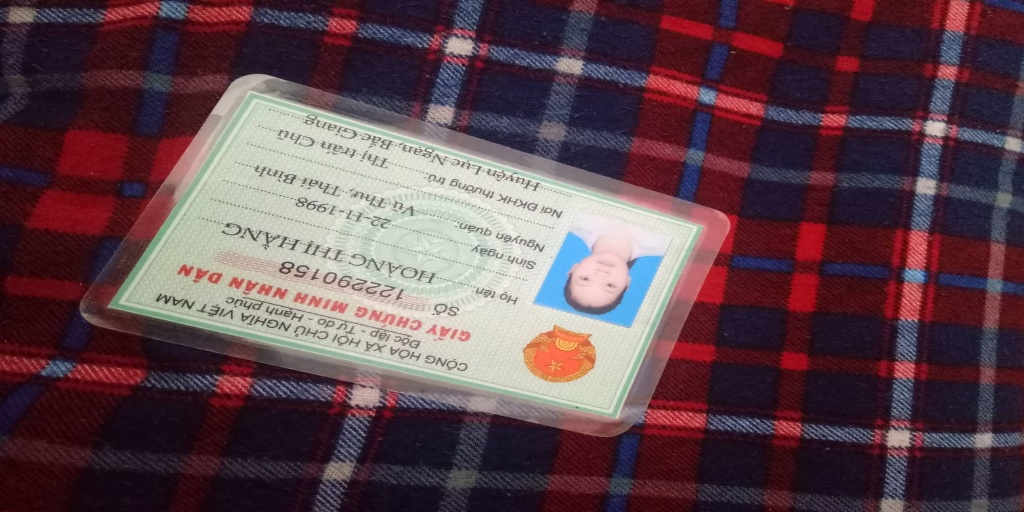

In [0]:
Image('test_result/67200737_335414677387591_6802810451164921856_n.jpg')

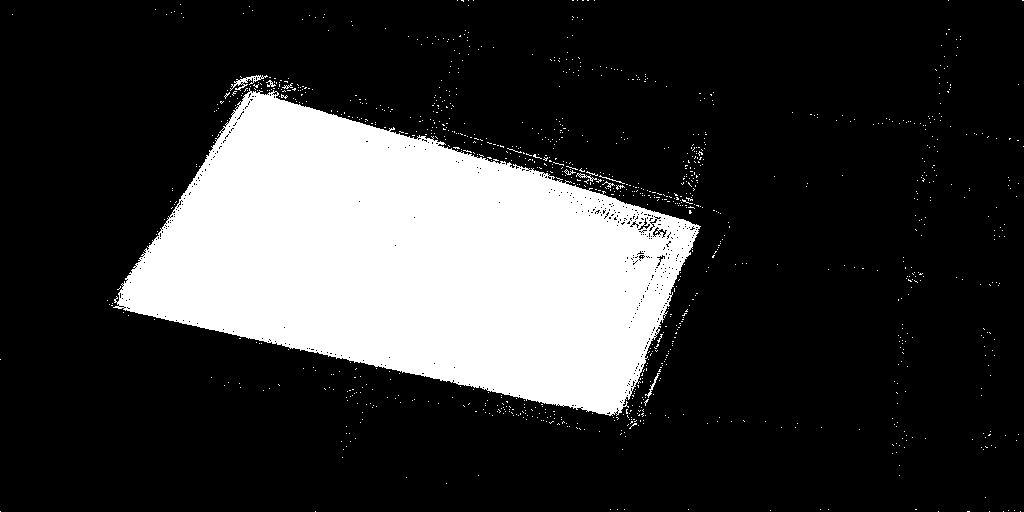

In [0]:
Image('test_result/67200737_335414677387591_6802810451164921856_n_ret.jpg')

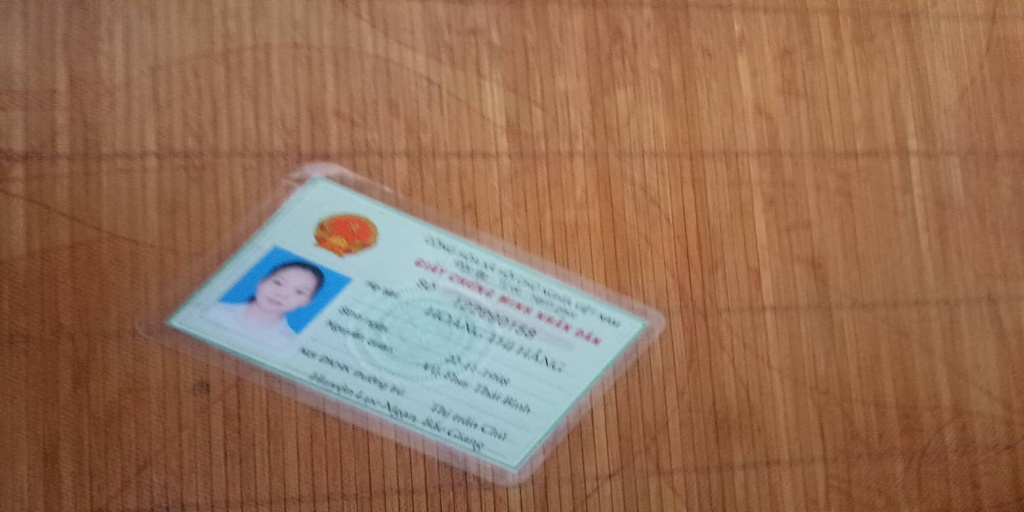

In [0]:
Image('test_result/67082392_374558049930034_5250723288887328768_n.jpg')

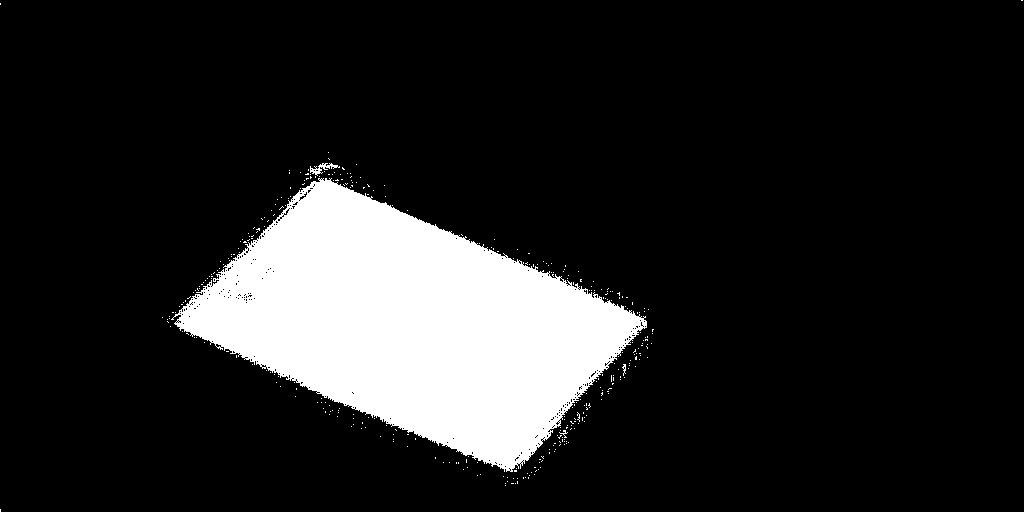

In [0]:
Image('test_result/67082392_374558049930034_5250723288887328768_n_ret.jpg')

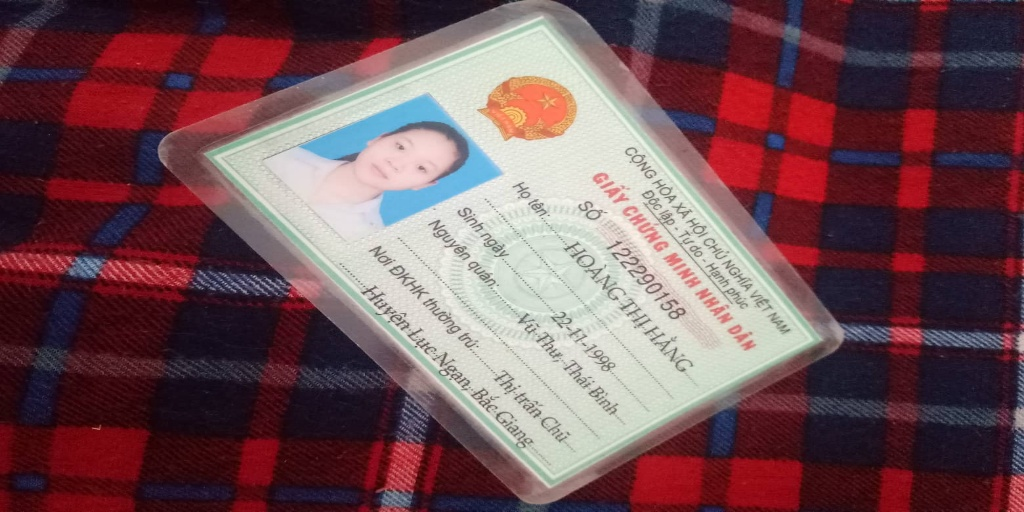

In [0]:
Image('test_result/67075679_347700702823646_8714707347613679616_n.jpg')

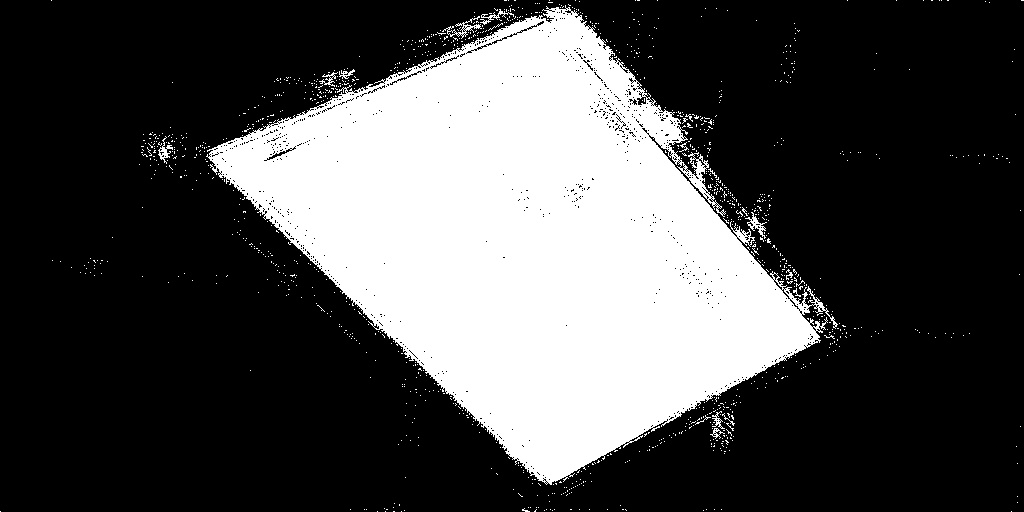

In [0]:
Image('test_result/67075679_347700702823646_8714707347613679616_n_ret.jpg')

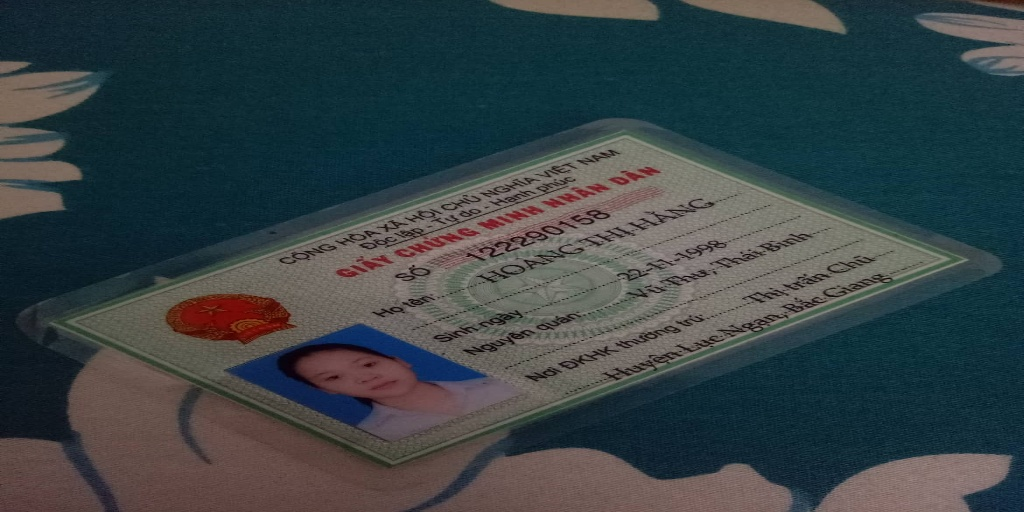

In [0]:
Image('test_result/67289330_430710934185821_3080921577773072384_n.jpg')

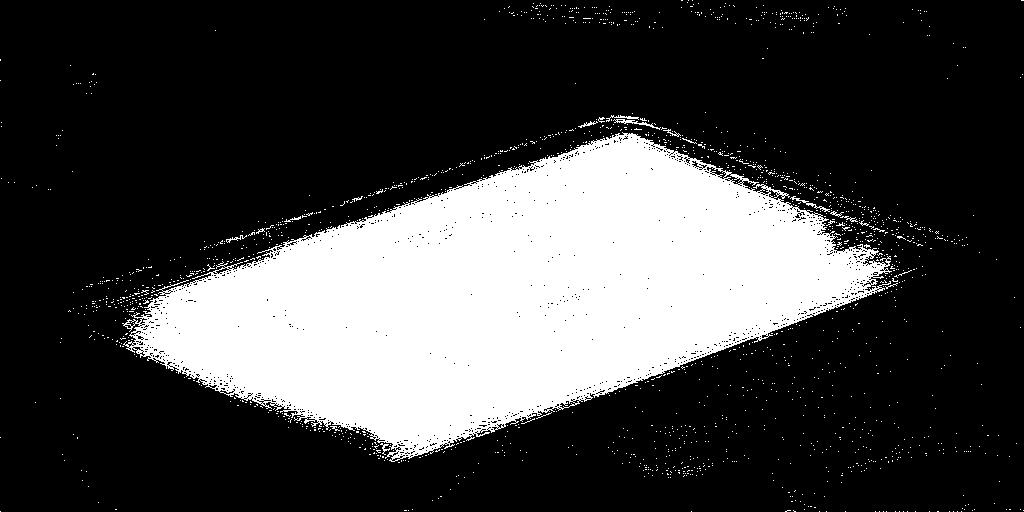

In [0]:
Image('test_result/67289330_430710934185821_3080921577773072384_n_ret.jpg')

# 5.Output and evaluate

In [0]:
export_dir = './exported_model'
graph=tf.Graph()
sess=tf.Session(graph=graph)
tf.saved_model.loader.load(sess, ["serve"], export_dir)
graph2=tf.get_default_graph()

W0722 18:16:02.961891 139946620581760 deprecation.py:323] From <ipython-input-10-864feca9efbf>:4: load (from tensorflow.python.saved_model.loader_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
W0722 18:16:14.049039 139946620581760 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


## 5.1. Visualize graph

In [0]:
from IPython.display import clear_output, Image, display, HTML

# Helper functions for TF Graph visualization

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = tf.compat.as_bytes("<stripped %d bytes>"%size)
    return strip_def
  
def rename_nodes(graph_def, rename_func):
    res_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add() 
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def
  
def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:1600px;height:1240px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [0]:
show_graph(graph)

## Visualize results

In [0]:
from matplotlib import pyplot as plt
def detect(img_path):
    img=cv2.imread(img_path)
    img=cv2.resize(img,(1536,864))
    im_softmax = sess.run(
        'outputs_1:0',
        {"image_input:0": [img]})[0]


    return img,im_softmax
  
def detect_img(img):
    im_softmax = sess.run(
        'outputs_1:0',
        {"image_input:0": [img]})[0]
    return im_softmax*255

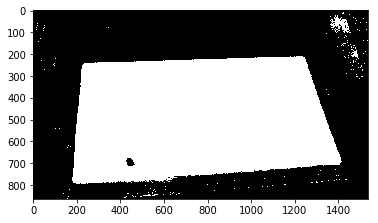

In [0]:
ret=detect('test/IMG_20190722_182751.jpg')
plt.imshow(ret,cmap='gray')


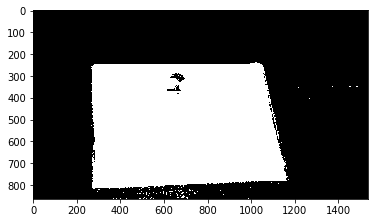

In [0]:
ret=detect('test/IMG_20190722_182807.jpg')
plt.imshow(ret,cmap='gray')

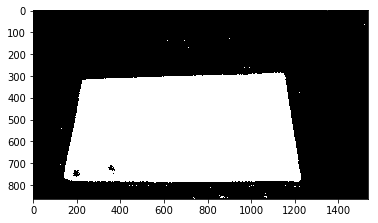

In [0]:
ret=detect('test/IMG_20190722_182821.jpg')
plt.imshow(ret,cmap='gray')

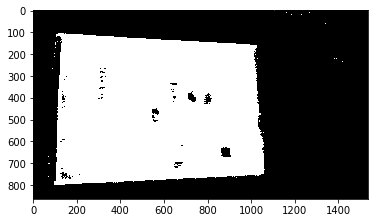

In [0]:
ret=detect('test/IMG_20190722_182832.jpg')
plt.imshow(ret,cmap='gray')

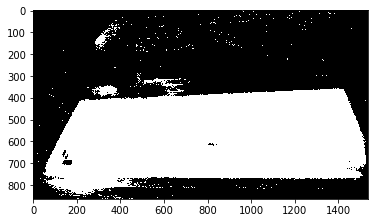

In [0]:
ret=detect('test/IMG_20190722_210513.jpg')
plt.imshow(ret,cmap='gray')

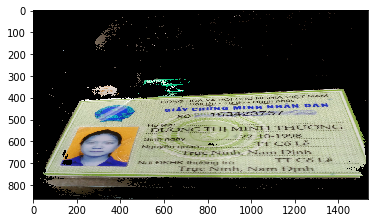

In [0]:
ori,ret=detect('test/IMG_20190722_210513.jpg')
new_ori=ori*ret[:,:,None]
plt.imshow(new_ori)
# plt.imshow(ret,cmap='gray')


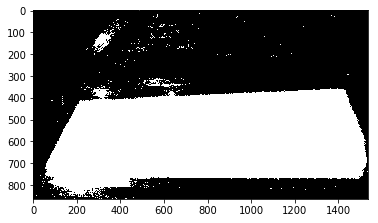

In [0]:
ret2=detect_img(new_ori)
plt.imshow(ret2,cmap='gray')

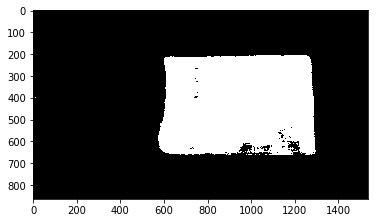

In [0]:
ret=detect('test/IMG_20190722_210527.jpg')
plt.imshow(ret,cmap='gray')

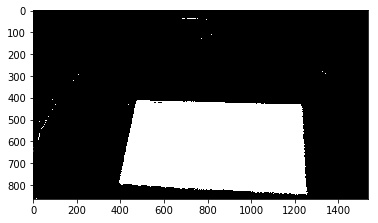

In [0]:
ret=detect('test/IMG_20190722_210549.jpg')
plt.imshow(ret,cmap='gray')

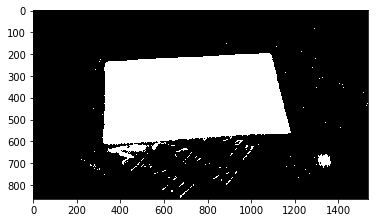

In [0]:
ret=detect('test/IMG_20190722_210600.jpg')
plt.imshow(ret,cmap='gray')

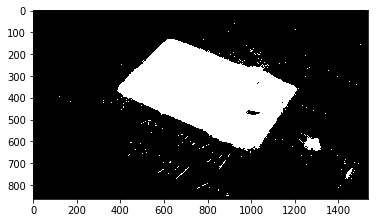

In [0]:
ret=detect('test/IMG_20190722_210606.jpg')
plt.imshow(ret,cmap='gray')

In [0]:
import PIL
import imageio

def trainId2Mask(img):
  out=np.zeros((img.shape[0],img.shape[1],4),dtype=np.uint8)
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      out[i,j]=labels.trainId2Mask[img[i,j]]
  return PIL.Image.fromarray(out,mode='RGBA')

In [0]:
from IPython.display import display

def visualize(sess,img_path):
  """
  Function to visualize model's output
  """
  img=cv2.imread(img_path)
  img_label=sess.run(
        'outputs_1:0',
        {"image_input:0": [img]})[0]
  
  img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  mask=trainId2Mask(img_label)
  img=PIL.Image.fromarray(img,mode='RGB')
  img.paste(mask,box=None,mask=mask)
  out_path=os.path.join('visualize',os.path.basename(img_path))
  img.save(out_path)
  i=Image(out_path)
  display(i)